<a href="https://colab.research.google.com/github/nabilaekasd/sentiment-analysis-import-trump/blob/main/analisis_sentimen_tarif_impor_donald_trump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.9 MB/s eta 0:00:00


In [ ]:
#@title prepo

import pandas as pd
import re
from unidecode import unidecode
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# 1. Load data dari Google Sheets
sheet_id = "16q5nzeH8AZ688QNeGXw3QRmzK8OC8tshM91c31_oAi4"
sheet_name = "Label_Manual"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

# Pastikan kolom teks ada dan tidak kosong
df = df[df['cleaned_text'].notna()].copy()

# 2. Cleansing
def clean_text(text):
    text = unidecode(text)
    text = re.sub(r'RT\s+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text.strip()

df['clean_text'] = df['cleaned_text'].astype(str).apply(clean_text)

# 3. Case Folding
df['casefold_text'] = df['clean_text'].str.lower()

# 4. Load kamus normalisasi
kamus_sheet_name = "Sheet10"
kamus_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={kamus_sheet_name}"
df_norm = pd.read_csv(kamus_url)
df_norm = df_norm.iloc[:, :2]
df_norm.columns = ['tidak_baku', 'baku']
df_norm['tidak_baku'] = df_norm['tidak_baku'].astype(str).str.strip().str.lower()
df_norm['baku'] = df_norm['baku'].astype(str).str.strip().str.lower()

# Buat kamus normalisasi
kamus_normalisasi = {
    tidak_baku: baku for tidak_baku, baku in zip(df_norm['tidak_baku'], df_norm['baku'])
    if tidak_baku.isalpha()
}

# 5. Normalisasi
def normalize_text(text):
    tokens = text.split()
    return ' '.join([kamus_normalisasi.get(token, token) for token in tokens])

df['normalized_text'] = df['casefold_text'].apply(normalize_text)

# 6. Tokenisasi + Stopword Removal
stopword_sheet_name = "stopword"
stopword_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={stopword_sheet_name}"
stopword_df = pd.read_csv(stopword_url)

for col in stopword_df.columns:
    stopword_df[col] = stopword_df[col].astype(str).str.strip().str.lower()

custom_stopwords = list(set(
    word for col in stopword_df.columns for word in stopword_df[col].dropna().astype(str).str.lower().tolist()
    if word not in ['nan', '', 'none']
))

def token_stopword(text):
    tokens = text.split()
    return [word for word in tokens if word not in custom_stopwords]

df['tokenized'] = df['normalized_text'].apply(token_stopword)

# 7. Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

df['stemmed'] = df['tokenized'].apply(stem_tokens)

# 8. Tampilkan hasil akhir
print("\n=== Hasil Preprocessing 5 Baris Pertama ===")
print("Original Text:\n", df['full_text'].head(), "\n")
print("Cleaned Text:\n", df['clean_text'].head(), "\n")
print("Casefolded Text:\n", df['casefold_text'].head(), "\n")
print("Normalized Text:\n", df['normalized_text'].head(), "\n")
print("Tokenized (No Stopword):\n", df['tokenized'].head(), "\n")
print("Stemmed Tokens:\n", df['stemmed'].head(), "\n")


=== Hasil Preprocessing 5 Baris Pertama ===
Original Text:
 0    Presiden Prabowo Subianto akhirnya buka suara ...
1    @IndoPopBase Sorry bukan maksud bela pemerinta...
2    Presiden Amerika Serikat Donald Trump resmi me...
3    @txtfromIR Penentuan tarifnya dr trade AS dgn ...
4    Tim Negoisasi yg Brillian dan Cemerlang dipimp...
Name: full_text, dtype: object 

Cleaned Text:
 0    Presiden Prabowo Subianto akhirnya buka suara ...
1    Sorry bukan maksud bela pemerintah tapi yg dim...
2    Presiden Amerika Serikat Donald Trump resmi me...
3    Penentuan tarifnya dr trade AS dgn tiap negara...
4    Tim Negoisasi yg Brillian dan Cemerlang dipimp...
Name: clean_text, dtype: object 

Casefolded Text:
 0    presiden prabowo subianto akhirnya buka suara ...
1    sorry bukan maksud bela pemerintah tapi yg dim...
2    presiden amerika serikat donald trump resmi me...
3    penentuan tarifnya dr trade as dgn tiap negara...
4    tim negoisasi yg brillian dan cemerlang dipimp...
Name: casefold

In [ ]:
#@title simpan prepo

# Simpan hasil preprocessing ke Google Drive (CSV)

# Tentukan path penyimpanan
save_path = '/content/drive/MyDrive/Metopen/preprocessing.csv'

# Simpan dataframe
df[['cleaned_text', 'clean_text', 'casefold_text', 'normalized_text', 'tokenized', 'stemmed']].to_csv(save_path, index=False)

print(f"Hasil preprocessing berhasil disimpan ke: {save_path}")

Hasil preprocessing berhasil disimpan ke: /content/drive/MyDrive/Metopen/preprocessing.csv


In [ ]:
#@title unduh tfidf

# -----------------------------
# 1. Load data dari Google Sheets
# -----------------------------
sheet_id = "16q5nzeH8AZ688QNeGXw3QRmzK8OC8tshM91c31_oAi4"  # ganti dengan ID Google Sheet kamu
sheet_name = "prepo"       # ganti dengan nama sheet kamu
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

# Pastikan kolom teks ada dan tidak kosong
df = df[df['stemmed'].notna()].copy()

# Hitung rata-rata TF-IDF
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Konversi ke DataFrame agar punya 2 kolom: 'kata' dan 'TF-IDF'
top_tfidf_df = pd.DataFrame({
    'kata': tfidf_mean.index,
    'TF-IDF': tfidf_mean.values
})

# Tampilkan
print(top_tfidf_df)

# Simpan ke file CSV
top_tfidf_df.to_csv('/content/drive/MyDrive/Metopen/2ttfidf.csv', index=False)

print("\n✅ Hasil sudah disimpan sebagai 'tfidf.csv'")

           kata    TF-IDF
0         tarif  0.062889
1       amerika  0.058017
2     indonesia  0.056763
3       serikat  0.055409
4         trump  0.049062
...         ...       ...
8956        tyi  0.000018
8957      agree  0.000018
8958     cannot  0.000018
8959  shopeepay  0.000017
8960        bgs  0.000017

[8961 rows x 2 columns]

✅ Hasil sudah disimpan sebagai 'tfidf.csv'


In [ ]:
import pandas as pd
import numpy as np
import ast

# 1. Load data dari Google Sheets
sheet_id = "16q5nzeH8AZ688QNeGXw3QRmzK8OC8tshM91c31_oAi4"
sheet_name = "prepo"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

# Pastikan kolom teks ada dan tidak kosong
df = df[df['stemmed'].notna()].copy()

# Ubah string ke list
df['stemmed'] = df['stemmed'].apply(ast.literal_eval)

# 2. Kamus kata lexicon
lexicon_sheet_name = "lexicon"
lexicon_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={lexicon_sheet_name}"
lexicon_df = pd.read_csv(lexicon_url)
lexicon_df.columns = ['kata', 'sentimen']

# Ubah ke dictionary
kamus_lexicon = dict(zip(lexicon_df['kata'], lexicon_df['sentimen']))

# 3. Perhitungan lexicon
def label_sentimen(tokens):
    positif = negatif = 0
    jumlah_kata = len(tokens)

    for kata in tokens:
        sentimen = kamus_lexicon.get(kata)
        if sentimen == 'positif':
            positif += 1
        elif sentimen == 'negatif':
            negatif += 1

    if jumlah_kata == 0:
        return 'netral'

    stsc = (positif - negatif) / jumlah_kata

    if stsc > 0:
        return 'positif'
    elif stsc < 0:
        return 'negatif'
    else:
        return 'netral'

# Terapkan ke dataframe
df['sentimen'] = df['stemmed'].apply(label_sentimen)

# Cetak hasil
print("\n=== Contoh Hasil Pelabelan ===")
print(df[['stemmed', 'sentimen']].head(10).to_string(index=False))

# Ringkasan
print("\n=== Ringkasan Sentimen ===")
print(df['sentimen'].value_counts())



=== Contoh Hasil Pelabelan ===
                                                                                                                                                                                                                                                                                                   stemmed sentimen
                                                                                               [presiden, prabowo, subianto, buka, suara, tarif, impor, presiden, amerika serikat, donald, trump, negara, indonesia, kena, persen, turut, tidak, masalah, prabowo, indonesia, kuat, hadap, perang, dagang]  negatif
                                                                                                                                    [maaf, maksud, bela, perintah, yang, tarif, tekstil, garmen, yang, memang, sudah, kena, tambah, bijak, tambah, tarif, standar, trump, yang, tibatiba, ubah, indonesia]  positif
                                            

In [ ]:
#@title simpan sentimen

# Simpan hasil sentimen ke Google Drive (CSV)

# Tentukan path penyimpanan
save_path = '/content/drive/MyDrive/Metopen/sentimen.csv'

# Simpan dataframe
df[['cleaned_text', 'sentimen']].to_csv(save_path, index=False)

print(f"Hasil sentimen berhasil disimpan ke: {save_path}")

Hasil sentimen berhasil disimpan ke: /content/drive/MyDrive/Metopen/sentimen.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title SESUDAH.TF-IDF

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# 1. Load data dari Google Sheets
sheet_id = "16q5nzeH8AZ688QNeGXw3QRmzK8OC8tshM91c31_oAi4"
sheet_name = "prepo"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

# Pastikan kolom 'stemmed' ada dan tidak kosong
df = df[df['stemmed'].notna()].copy()
df['final_text'] = df['stemmed'].astype(str)

# 2. Ambil Label Sentimen
labels = df['sentimen'].astype(str)

# 3. Ekstrak Kata Penting (Top N dari Positif & Negatif)
kata_positif = [kata for teks, label in zip(df['final_text'], labels) if label == 'positif' for kata in teks.split()]
top_positif = [x[0] for x in Counter(kata_positif).most_common(500)]

kata_negatif = [kata for teks, label in zip(df['final_text'], labels) if label == 'negatif' for kata in teks.split()]
top_negatif = [x[0] for x in Counter(kata_negatif).most_common(500)]

# Gabungkan semua kata penting
kata_penting = set(top_positif + top_negatif)

# 4. Perbesar Bobot Kata Penting
def perbesar_kata_penting(text, kata_penting):
    tokens = text.split()
    hasil = []
    for t in tokens:
        if t in kata_penting:
            hasil.extend([t] * 3)
        else:
            hasil.append(t)
    return ' '.join(hasil)

data_berbobot = [perbesar_kata_penting(t, kata_penting) for t in df['final_text']]

# 5. TF-IDF dengan Unigram
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=2, max_df=0.95)
tfidf_matrix = tfidf_vectorizer.fit_transform(data_berbobot)

# 6. Konversi ke DataFrame untuk eksplorasi
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# 7. Cek Hasil
print("TF-IDF Shape:", tfidf_df.shape)
print("\nTop 5 Kata dengan Rata-rata Bobot TF-IDF Tertinggi:")
print(tfidf_df.mean().sort_values(ascending=False).head())


TF-IDF Shape: (10154, 4131)

Top 5 Kata dengan Rata-rata Bobot TF-IDF Tertinggi:
tarif        0.080499
amerika      0.073159
indonesia    0.071010
serikat      0.070077
trump        0.065107
dtype: float64


In [ ]:
#@title SVM

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC

# Label
y = df['sentimen']
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.2, stratify=y, random_state=42)

# Seleksi fitur
selector = SelectKBest(score_func=chi2, k=1000)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Tuning SVM
svc = LinearSVC(max_iter=15000)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(svc, param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train_sel, y_train)

# Model terbaik
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_sel)

Akurasi: 81.14%


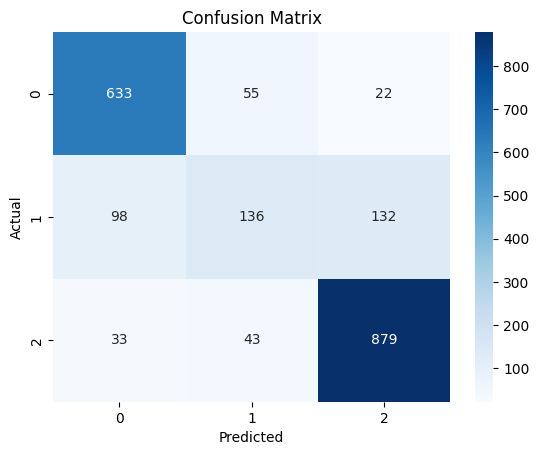


Metrik Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.83      0.89      0.86       710
      netral       0.58      0.37      0.45       366
     positif       0.85      0.92      0.88       955

    accuracy                           0.81      2031
   macro avg       0.75      0.73      0.73      2031
weighted avg       0.79      0.81      0.80      2031



In [ ]:
#@title SESUDAH.Evaluasi SVM

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Laporan Klasifikasi
print("\nMetrik Klasifikasi:")
print(classification_report(y_test, y_pred))


FastText & BiLSTM

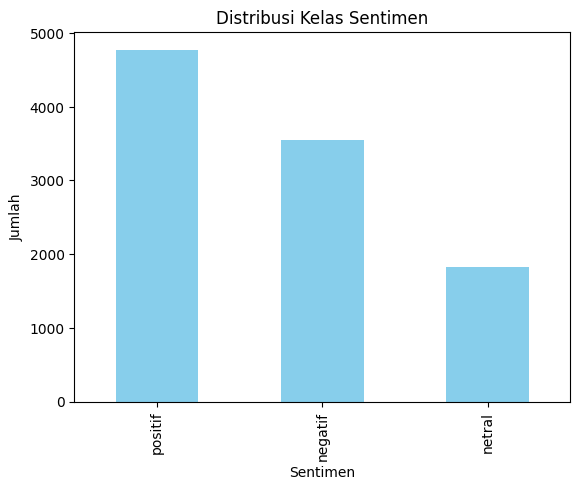

In [ ]:
import matplotlib.pyplot as plt

df['sentimen'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribusi Kelas Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

In [ ]:
from sklearn.utils import resample

# Pisahkan data per kelas
df_positif = df[df['sentimen'] == 'positif']
df_negatif = df[df['sentimen'] == 'negatif']
df_netral  = df[df['sentimen'] == 'netral']

# Oversampling kelas netral hingga seimbang dengan positif (misal 4800)
df_netral_upsampled = resample(df_netral,
                               replace=True,     # Duplikasi
                               n_samples=len(df_positif), # Target jumlah
                               random_state=42)

# Gabungkan kembali
df_balanced = pd.concat([df_positif, df_negatif, df_netral_upsampled])

# Acak ulang data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 507.6 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.0-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.0-py3-none-any.whl (292 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4508434 sha256=c734d60c224cc0570dcdaa96534338f2700c28a4f30d0fc00e59ba1fe59e7eee
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz

--2025-07-28 04:17:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.183.121, 13.33.183.29, 13.33.183.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.183.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G  49.8MB/s    in 25s     

2025-07-28 04:18:12 (46.6 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



In [ ]:
!pip install seaborn scikit-learn

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 486.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfr

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

In [ ]:
# 2. LOAD DATASET
sheet_id = "16q5nzeH8AZ688QNeGXw3QRmzK8OC8tshM91c31_oAi4"
sheet_name = "Hasil_Lexicon"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

# 3. OVERSAMPLING KELAS NETRAL
df_positif = df[df['sentimen'] == 'positif']
df_negatif = df[df['sentimen'] == 'negatif']
df_netral  = df[df['sentimen'] == 'netral']

# Samakan jumlah dengan kelas positif
df_netral_upsampled = resample(df_netral, replace=True, n_samples=len(df_positif), random_state=42)

# Gabungkan kembali dan acak
df_balanced = pd.concat([df_positif, df_negatif, df_netral_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# 4. SIAPKAN TEKS DAN LABEL
label_mapping = {'negatif': 0, 'netral': 1, 'positif': 2}
df_balanced['label'] = df_balanced['sentimen'].map(label_mapping)

texts = df_balanced['stemmed'].astype(str).tolist()
labels = df_balanced['label'].tolist()

In [ ]:
# 5. TOKENISASI DAN PAD
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

max_len = 50  # panjang maksimal kalimat
X = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(labels, num_classes=3)

In [ ]:
# 6. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Load FastText ke dictionary
fasttext_embeddings = {}
with open("cc.id.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        fasttext_embeddings[word] = vector

In [ ]:
# 7. BUAT EMBEDDING MATRIX
# Muat FastText
import gensim.downloader as api
fasttext = api.load('fasttext-wiki-news-subwords-300')  # bisa diganti

# Buat embedding_matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in fasttext:
        embedding_matrix[i] = fasttext[word]

In [ ]:
# 8. BANGUN MODEL BiLSTM
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True
))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build dan tampilkan ringkasan
model.build(input_shape=(None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 300)        │     2,734,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,921,467 (11.14 MB)

 Trainable params: 2,921,467 (11.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8. TRAINING
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 62s 181ms/step - accuracy: 0.5479 - loss: 0.8813 - val_accuracy: 0.7958 - val_loss: 0.4747
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 80s 176ms/step - accuracy: 0.8931 - loss: 0.2865 - val_accuracy: 0.8569 - val_loss: 0.3813
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 84s 184ms/step - accuracy: 0.9501 - loss: 0.1573 - val_accuracy: 0.8817 - val_loss: 0.3480
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 53s 180ms/step - accuracy: 0.9719 - loss: 0.0900 - val_accuracy: 0.8912 - val_loss: 0.3857
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 53s 180ms/step - accuracy: 0.9780 - loss: 0.0708 - val_accuracy: 0.8893 - val_loss: 0.4168
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.9845 - loss: 0.0501 - val_accuracy: 0.8826 - val_loss: 0.5002
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 52s 176ms/step - accuracy: 0.9941 - loss: 0.0222 - val_accuracy: 0.8989 - val_loss: 0.4751
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 85s 185ms/step - accuracy: 0.9893 - loss: 0

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step

Akurasi: 91.37%

=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.97      0.87      0.92       681
      Netral       0.85      0.96      0.90       984
     Positif       0.96      0.90      0.93       955

    accuracy                           0.91      2620
   macro avg       0.93      0.91      0.91      2620
weighted avg       0.92      0.91      0.91      2620



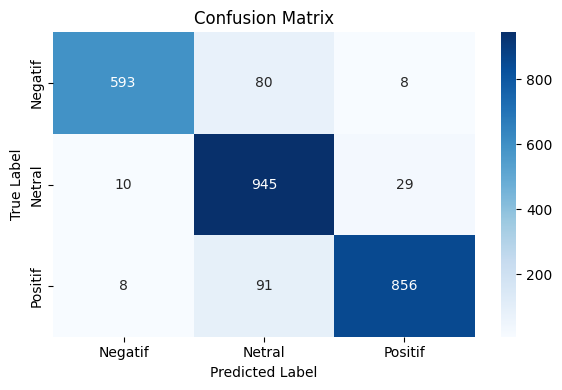

In [ ]:
# 9. EVALUASI MODEL
# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Skor Akurasi
acc = accuracy_score(y_true, y_pred)
print(f"\nAkurasi: {acc * 100:.2f}%")

# Classification report
target_names = ['Negatif', 'Netral', 'Positif']
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan 10 kata pertama dari tokenizer
for word, idx in list(tokenizer.word_index.items())[:20]:
    print(f"{word} => index {idx}")

'tarif' => index 1
'indonesia' => index 2
'amerika => index 3
serikat' => index 4
'trump' => index 5
'impor' => index 6
'naik' => index 7
'ekspor' => index 8
'ekonomi' => index 9
'barang' => index 10
'bijak' => index 11
'tidak' => index 12
'dagang' => index 13
'harga' => index 14
'pasar' => index 15
'rupiah' => index 16
'amerika' => index 17
'lebih' => index 18
'dampak' => index 19
'negosiasi' => index 20


In [ ]:
# Daftar kata yang ingin ditampilkan vektor embedding-nya
kata_kunci = ['tarif', 'indonesia', 'amerika', 'trump', 'impor']

for kata in kata_kunci:
    if kata in fasttext:
        print(f"\nKata: '{kata}' ditemukan.")
        print(f"Vektor embedding (10 dimensi pertama):\n{fasttext[kata][:10]}")
    else:
        print(f"\nKata: '{kata}' TIDAK ditemukan di FastText.")


Kata: 'tarif' ditemukan.
Vektor embedding (10 dimensi pertama):
[-0.024415  -0.038058   0.01776   -0.041939   0.0041631 -0.079742
  0.023265  -0.059514   0.031414  -0.039461 ]

Kata: 'indonesia' ditemukan.
Vektor embedding (10 dimensi pertama):
[-0.0067595 -0.024917  -0.047009   0.044102   0.021077  -0.027418
 -0.076521  -0.048448   0.0046867  0.01567  ]

Kata: 'amerika' ditemukan.
Vektor embedding (10 dimensi pertama):
[ 0.02941    0.013882  -0.020874   0.023386  -0.018875   0.013599
  0.030772  -0.11004   -0.016251   0.0024885]

Kata: 'trump' ditemukan.
Vektor embedding (10 dimensi pertama):
[ 0.017575 -0.042547 -0.14832   0.071423 -0.10738  -0.106    -0.011851
 -0.10926   0.0491    0.031474]

Kata: 'impor' ditemukan.
Vektor embedding (10 dimensi pertama):
[ 0.0031951  0.036382  -0.041156   0.0028299  0.0096529 -0.0023185
 -0.082532  -0.056598  -0.002607  -0.026075 ]


/tmp/ipython-input-25-4003750595.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette=colors)


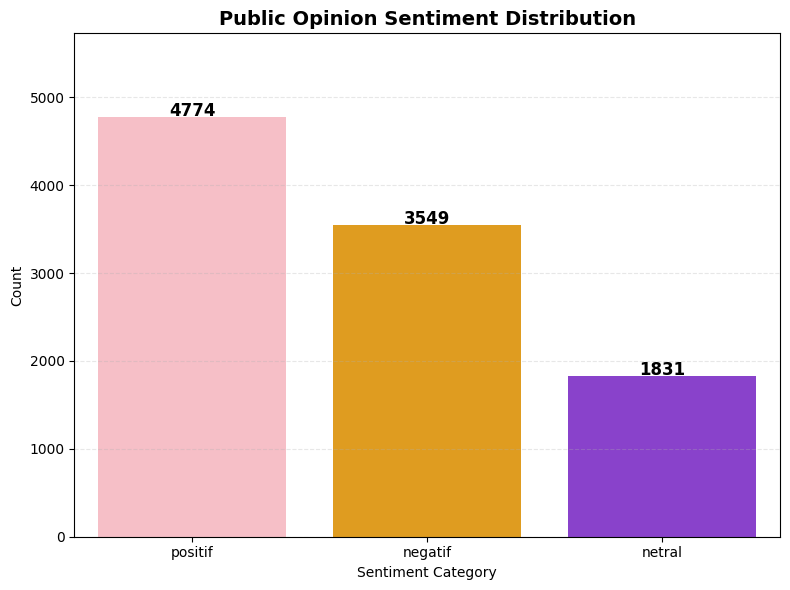

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data dari Google Sheets
sheet_id = "16q5nzeH8AZ688QNeGXw3QRmzK8OC8tshM91c31_oAi4"
sheet_name = "Hasil_Lexicon"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df = pd.read_csv(url)

# Normalisasi kolom dan isi
df.columns = df.columns.str.strip().str.lower()
df['sentimen'] = df['sentimen'].str.lower().str.strip()

# Hitung dan urutkan distribusi sentimen
sentimen_counts = df['sentimen'].value_counts().sort_values(ascending=False)

# Warna custom sesuai slide kamu
custom_palette = {
    'positif': '#FFB6C1',
    'netral': '#8A2BE2',
    'negatif': '#FFA500'
}

# Ambil warna
colors = [custom_palette[s] for s in sentimen_counts.index]

# Plot bar
plt.figure(figsize=(8, 6))
sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette=colors)

# Tambahkan label jumlah
for i, val in enumerate(sentimen_counts.values):
    plt.text(i, val + 10, str(val), ha='center', fontsize=12, weight='bold')

# Set judul dan label
plt.title("Public Opinion Sentiment Distribution", fontsize=14, weight='bold')
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.ylim(0, sentimen_counts.max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

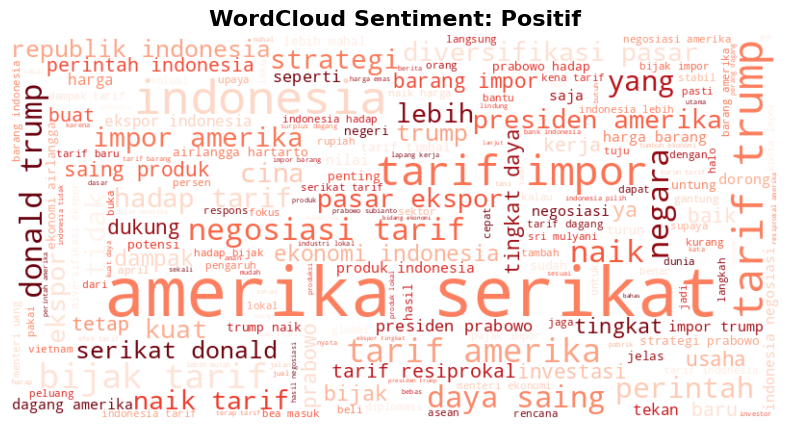

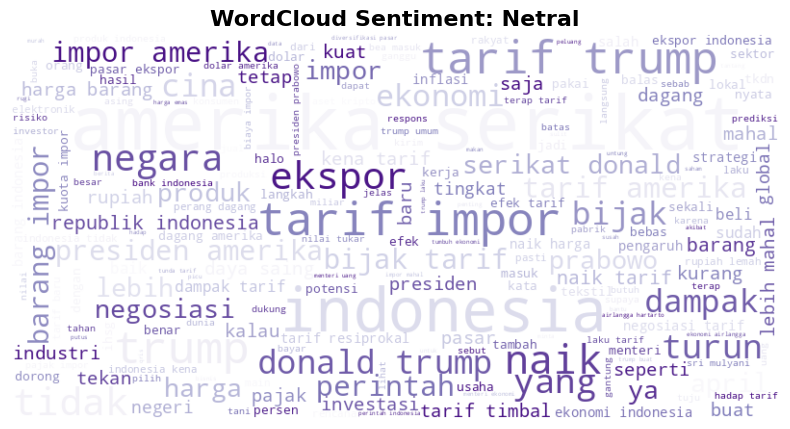

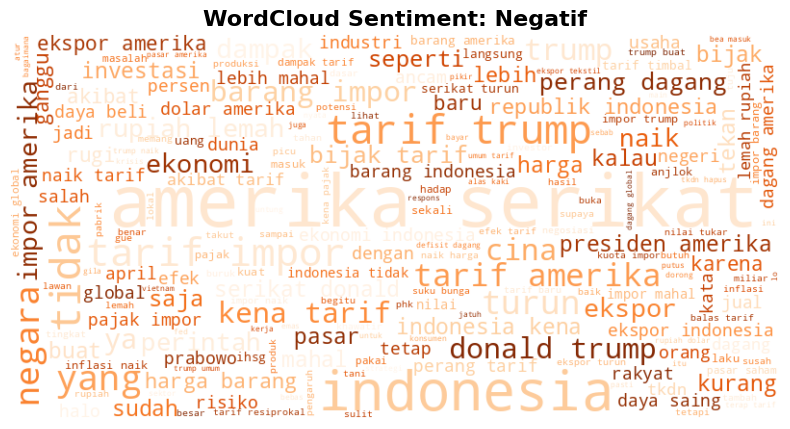

In [ ]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

import string

def clean_text(text):
    # Hapus tanda baca termasuk tanda petik
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Hapus angka dan karakter selain huruf
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def plot_wordcloud(sentiment_label, color):
    if 'stemmed' not in df.columns:
        print(f"Kolom 'stemmed' tidak ditemukan!")
        return
    # Gabungkan teks dan bersihkan dari simbol
    texts = df[df['sentimen'] == sentiment_label]['stemmed'].dropna().apply(clean_text)
    text = " ".join(texts)

    if not text.strip():
        print(f"Tidak ada teks untuk sentimen '{sentiment_label}'.")
        return
    wc = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud Sentiment: {sentiment_label.capitalize()}", fontsize=16, weight='bold')
    plt.show()

plot_wordcloud('positif', 'Reds')
plot_wordcloud('netral', 'Purples')
plot_wordcloud('negatif', 'Oranges')

